In [52]:
import numpy as np
import pandas as pd
import os
import lhapdf
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Constants
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a**2)
m_p       = 0.938    # mass of proton in GeV.

In [188]:
class DIS:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.xfxQ2_vec = np.vectorize(self.__call__)

    def __call__(self, i, x, q2):
        return self.pdf.xfxQ2(i, x, q2)
    
    def F2(self, x, q2):
        charge2 = [4/9, 1/9]
        result = 0
        for i in range(1, 6):
            result += charge2[i%2]*(self.xfxQ2_vec(i, x, q2) + self.xfxQ2_vec(-i, x, q2))
            
        return result
    
    def F1(self, x, q2):
        return self.F2(x, q2)/(2*x)
    
    def dsigma(self, E, x, y):
        q2 = 2*m_p*E*x*y
        s = q2/(x*y) + m_p**2
        gevtocm = 0.19733**2*1e-26
        ds2 = prefactor*s/q2/q2*(self.F2(x, q2)*(1-y)+self.F1(x, q2)*x*y**2)
        return ds2*gevtocm*1e+32/E

In [189]:
class Dataset:
    """
    Class to store the data from Huma in a nice to access format
    """
    def __init__(self, prefix):
        self.filenames = [os.path.join(prefix, f) for f in os.listdir(prefix) if os.path.isfile(os.path.join(prefix, f)) and 'swp' not in f and 'DS' not in f]
        self.data = []
        for filename in self.filenames:
            pdf_set = filename.split('_')[-2]
            df = pd.read_csv(filename, sep='\s+', names=['E', 'Q2', 'x', 'y', 'F1', 'F2', 'sigma'], dtype=np.float64)
            df['pdf'] = pdf_set
            self.data.append(df)
        self.data = pd.concat(self.data)
        self.data = self.data.sort_values(by=['pdf', 'E'])
        
    def points(self):
        pdf_mask = self.data['pdf'] == 'cteq'
        return self.data[pdf_mask][['E', 'Q2', 'x', 'y']].to_numpy()
    
    def data(self, pdf_set):
        pdf_mask = self.data['pdf'] == pdf_set
        return self.data[pdf_mask][['F1', 'F2', 'sigma']]

In [190]:
dis = DIS("cteq66", 0)
dis_ct14lo = DIS("CT14nlo", 0)
data = Dataset('NumbersHuma')

In [191]:
data.data

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,cteq
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,cteq
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,cteq
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,cteq
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,cteq
...,...,...,...,...,...,...,...,...
185,15.0,20.055308,0.95,0.75,0.000019,0.000037,0.000001,mmht
186,15.0,21.392328,0.95,0.80,0.000019,0.000036,0.000001,mmht
187,15.0,22.729349,0.95,0.85,0.000018,0.000035,0.000001,mmht
188,15.0,24.066369,0.95,0.90,0.000018,0.000034,0.000001,mmht


In [192]:
mask = (data.data['E'] == 3) & (data.data['pdf'] == 'cteq')
E = 3.0
q2 = data.data[mask]['Q2'].to_numpy()
x = data.data[mask]['x'].to_numpy()
y = data.data[mask]['y'].to_numpy()
F1 = dis.F1(x, q2)
F2 = dis.F2(x, q2)
sigma = dis.dsigma(E, x, y)

F1_ct14lo = dis_ct14lo.F1(x, q2)
F2_ct14lo = dis_ct14lo.F2(x, q2)
sigma_ct14lo = dis_ct14lo.dsigma(E, x, y)

results = {'x': x, 'y': y, 'q2': q2, 'F1': F1, 'F2': F2, 'sigma': sigma, 'pdf': 'cteq66'}
results = pd.DataFrame(results)
results

results2 = {'x': x, 'y': y, 'q2': q2, 'F1': F1, 'F2': F2, 'sigma': sigma, 'pdf': 'CT14lo'}
results2 = pd.DataFrame(results2)

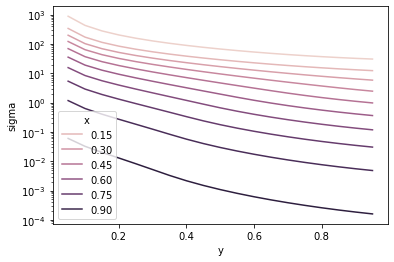

In [193]:
ax = sns.lineplot(x="y", y="sigma", hue="x", data=results)
ax.set_yscale('log')
plt.show()

In [199]:
experimental = pd.read_csv('ExperimentalData/HEPData-ins557597-v1-Table_1.csv', header=13, names=['Q2', 'x', 'y', 'F2', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
experimental['error'] = np.sqrt(experimental['stat+']**2 + experimental['sys+']**2)
experimental['Q2'].to_numpy()

array([2.7e+00, 2.7e+00, 2.7e+00, 2.7e+00, 3.5e+00, 3.5e+00, 3.5e+00,
       3.5e+00, 3.5e+00, 3.5e+00, 3.5e+00, 3.5e+00, 4.5e+00, 4.5e+00,
       4.5e+00, 4.5e+00, 4.5e+00, 6.5e+00, 6.5e+00, 6.5e+00, 6.5e+00,
       6.5e+00, 6.5e+00, 6.5e+00, 6.5e+00, 6.5e+00, 6.5e+00, 8.5e+00,
       8.5e+00, 8.5e+00, 8.5e+00, 8.5e+00, 8.5e+00, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.2e+01, 1.2e+01, 1.2e+01, 1.2e+01, 1.2e+01, 1.2e+01, 1.5e+01,
       1.5e+01, 1.5e+01, 1.5e+01, 1.5e+01, 1.5e+01, 1.5e+01, 1.5e+01,
       1.8e+01, 1.8e+01, 1.8e+01, 1.8e+01, 1.8e+01, 1.8e+01, 2.2e+01,
       2.2e+01, 2.2e+01, 2.2e+01, 2.2e+01, 2.2e+01, 2.2e+01, 2.2e+01,
       2.2e+01, 2.7e+01, 2.7e+01, 2.7e+01, 2.7e+01, 2.7e+01, 2.7e+01,
       2.7e+01, 2.7e+01, 3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01,
       3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01, 4.5e+01, 4.5e+01, 4.5e+01,
       4.5e+01, 4.5e+01, 4.5e+01, 4.5e+01, 4.5e+01, 6.0e+01, 6.0e+01,
       6.0e+01, 6.0e

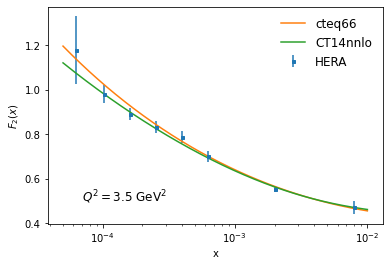

In [201]:
Q2 = 3.5

# Experiment
mask = experimental['Q2'] == Q2
exp = experimental[mask]
plt.errorbar(exp['x'], exp['F2'], yerr=exp['error'], label='HERA', ls='', marker='s', markersize='3')

# Theory
x = np.logspace(np.log10(exp['x'].min())-0.1, np.log10(exp['x'].max())+0.1, 1000)
F2_cteq66 = dis.F2(x, Q2)
F2_ct14lo = dis_ct14lo.F2(x, Q2)
plt.plot(x, F2_cteq66, label='cteq66')
plt.plot(x, F2_ct14lo, label='CT14nnlo')
plt.legend(frameon=False, fontsize=12)
plt.text(7e-5, 0.5, r'$Q^2 = 3.5$ GeV${}^2$', fontsize=12)
plt.xlabel('x')
plt.ylabel(r'$F_{2}(x)$')
plt.xscale('log')
plt.savefig('HeraCompare.pdf')
plt.show()

In [196]:
exp_sigma = pd.read_csv('ExperimentalData/HEPData-ins557597-v1-Table_1_xsec.csv', header=4, names=['Q2', 'x', 'y', 'sig', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
exp_sigma['error'] = np.sqrt(exp_sigma['stat+']**2 + exp_sigma['sys+']**2)
exp_sigma

,Q2,x,y,sig,stat+,stat-,sys+,sys-,error
0,2.7,0.000063,0.474,0.832,0.014,-0.014,0.039,-0.039,0.041437
1,2.7,0.000161,0.186,0.740,0.007,-0.007,0.018,-0.018,0.019313
2,2.7,0.000400,0.075,0.649,0.007,-0.007,0.025,-0.025,0.025962
3,2.7,0.000632,0.047,0.607,0.009,-0.009,0.026,-0.026,0.027514
4,2.7,0.002000,0.015,0.477,0.004,-0.004,0.020,-0.020,0.020396
...,...,...,...,...,...,...,...,...,...
237,12000.0,0.250000,0.532,0.172,0.045,-0.045,0.007,-0.007,0.045541
238,12000.0,0.400000,0.333,0.084,0.032,-0.032,0.003,-0.003,0.032140
239,20000.0,0.250000,0.887,0.161,0.057,-0.057,0.008,-0.008,0.057559
240,20000.0,0.400000,0.554,0.080,0.063,-0.063,0.011,-0.011,0.063953


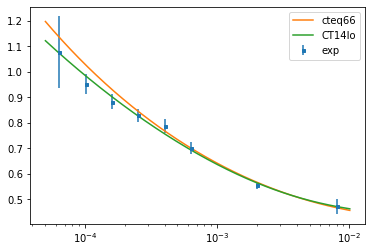

In [197]:
Q2 = 3.5

# Experiment
mask = exp_sigma['Q2'] == Q2
exp = exp_sigma[mask]
plt.errorbar(exp['x'], exp['sig'], yerr=exp['error'], label='exp', ls='', marker='s', markersize='3')

# Theory
x = np.logspace(np.log10(exp['x'].min())-0.1, np.log10(exp['x'].max())+0.1, 1000)
F2_cteq66 = dis.F2(x, Q2)
F2_ct14lo = dis_ct14lo.F2(x, Q2)
plt.plot(x, F2_cteq66, label='cteq66')
plt.plot(x, F2_ct14lo, label='CT14lo')
plt.legend()
plt.xscale('log')
plt.show()